
# EDA – Données météo IDF (Couche Silver)

Ce notebook explore le fichier **`data/silver/time_series/meteo_clean.parquet`** généré par la couche *Silver* :
- contrôle qualité et couverture
- saisonnalité et distributions
- identification d'épisodes pluvieux **intenses** (seuil par station, p95)
- préparation de **seuils** et artefacts utiles pour la couche *Gold* (ML météo-only)

> Le fichier contient ~3.7M lignes ; certaines cellules peuvent prendre du temps. Les visuels utilisent **matplotlib** (pas de dépendances exotiques).


## 1. Chargement et configuration

In [2]:

from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Recherche du chemin dataset (essayez plusieurs emplacements courants)
CANDIDATES = [
    Path("data/silver/time_series/meteo_clean.parquet"),
    Path("../data/silver/time_series/meteo_clean.parquet"),
    Path("../../data/silver/time_series/meteo_clean.parquet"),
]

DATA_PATH = None
for c in CANDIDATES:
    if c.exists():
        DATA_PATH = c
        break

assert DATA_PATH is not None, "Fichier meteo_clean.parquet introuvable. Ajustez CANDIDATES ci-dessus."

print("Fichier détecté:", DATA_PATH)

# Chargement
df = pd.read_parquet(DATA_PATH)

# Optimisations légères de types
for cat_col in ["NUM_POSTE", "NOM_USUEL"]:
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype("category")

df["date"] = pd.to_datetime(df["date"])

print(df.shape)
df.head(3)


Fichier détecté: data\silver\time_series\meteo_clean.parquet
(3766224, 22)


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,date,TN,TX,TM,RR,FFM,RR_7d,RR_14d,RR_30d,API,TM_7d,TM_30d,year,month,day_of_year,sin_doy,cos_doy
0,75101001,INNOCENTS,48.860667,2.348333,37,1950-01-01,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.00,NaN,NaN,1950,1,1,0.017202,0.999852
1,75101001,INNOCENTS,48.860667,2.348333,37,1950-01-02,NaN,NaN,NaN,1.8,NaN,1.8,1.8,1.8,1.80,NaN,NaN,1950,1,2,0.034398,0.999408
2,75101001,INNOCENTS,48.860667,2.348333,37,1950-01-03,NaN,NaN,NaN,2.0,NaN,3.8,3.8,3.8,3.62,NaN,NaN,1950,1,3,0.051584,0.998669


## 2. Vue d'ensemble & qualité

In [3]:

print("Période couverte :", df["date"].min().date(), "→", df["date"].max().date())
print("Nb de stations   :", df["NUM_POSTE"].nunique())
print("Colonnes         :", len(df.columns))
print(df.dtypes)

# Manquants par colonne
missing = df.isna().mean().sort_values(ascending=False)
missing.to_frame("missing_ratio").head(20)


Période couverte : 1950-01-01 → 2025-09-22
Nb de stations   : 357
Colonnes         : 22
NUM_POSTE            category
NOM_USUEL            category
LAT                   float64
LON                   float64
ALTI                    int64
date           datetime64[ns]
TN                    float64
TX                    float64
TM                    float64
RR                    float64
FFM                   float64
RR_7d                 float64
RR_14d                float64
RR_30d                float64
API                   float64
TM_7d                 float64
TM_30d                float64
year                    int32
month                   int32
day_of_year             int32
sin_doy               float64
cos_doy               float64
dtype: object


,missing_ratio
FFM,0.996373
TM,0.990665
TM_7d,0.990383
TM_30d,0.989718
TN,0.882552
TX,0.882513
RR,0.399590
RR_7d,0.389783
RR_14d,0.379465
RR_30d,0.358525


In [4]:

# Doublons de sécurité (la Silver les a déjà supprimés)
dups = df.duplicated(subset=["NUM_POSTE","date"]).sum()
print("Doublons (NUM_POSTE,date):", dups)

# Couverture par station
coverage = (df.groupby("NUM_POSTE")["date"]
              .agg(["min","max","count"])
              .sort_values("count", ascending=False))
coverage.head(10)


Doublons (NUM_POSTE,date): 0


C:\Users\djahe\AppData\Local\Temp\ipykernel_30684\2851526659.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage = (df.groupby("NUM_POSTE")["date"]


,min,max,count
NUM_POSTE,,,
95088001,1950-01-01,2025-09-22,27659
77239001,1950-01-01,2025-09-22,27659
75114001,1950-01-01,2025-09-22,27659
94068001,1950-01-01,2025-09-22,27659
78621001,1950-01-01,2025-09-22,27659
91027002,1950-01-01,2025-09-22,27659
77306001,1950-01-01,2025-09-22,27659
78640001,1950-01-01,2025-09-22,27659
91103001,1950-01-01,2025-09-22,27657


## 3. Distributions simples

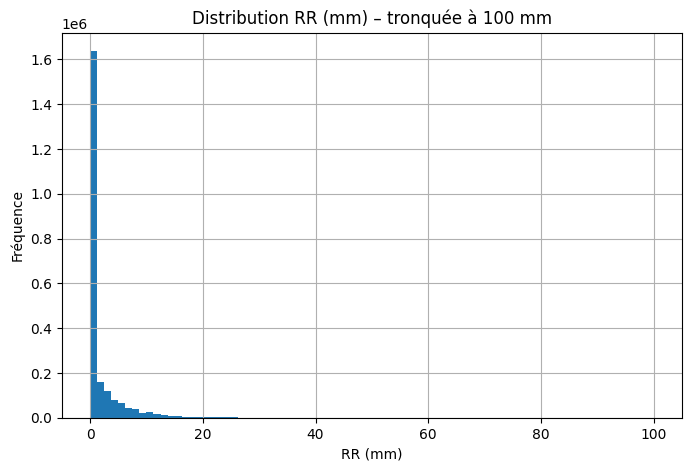

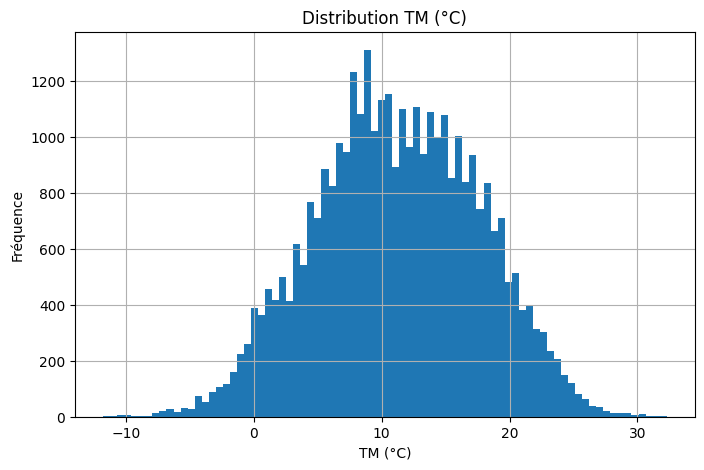

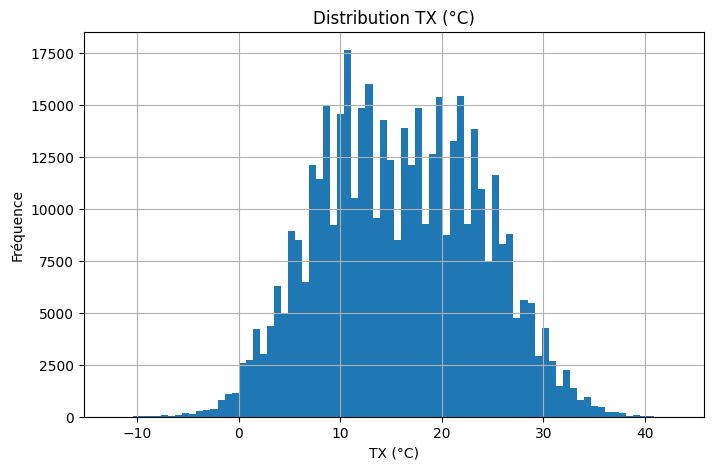

In [5]:

# Histogrammes simples (RR, TM, TX) - ATTENTION aux queues épaisses
fig, ax = plt.subplots(figsize=(8,5))
df["RR"].dropna().clip(upper=100).hist(bins=80, ax=ax)
ax.set_title("Distribution RR (mm) – tronquée à 100 mm")
ax.set_xlabel("RR (mm)"); ax.set_ylabel("Fréquence")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
df["TM"].dropna().hist(bins=80, ax=ax)
ax.set_title("Distribution TM (°C)")
ax.set_xlabel("TM (°C)"); ax.set_ylabel("Fréquence")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
df["TX"].dropna().hist(bins=80, ax=ax)
ax.set_title("Distribution TX (°C)")
ax.set_xlabel("TX (°C)"); ax.set_ylabel("Fréquence")
plt.show()


## 4. Saisonniété

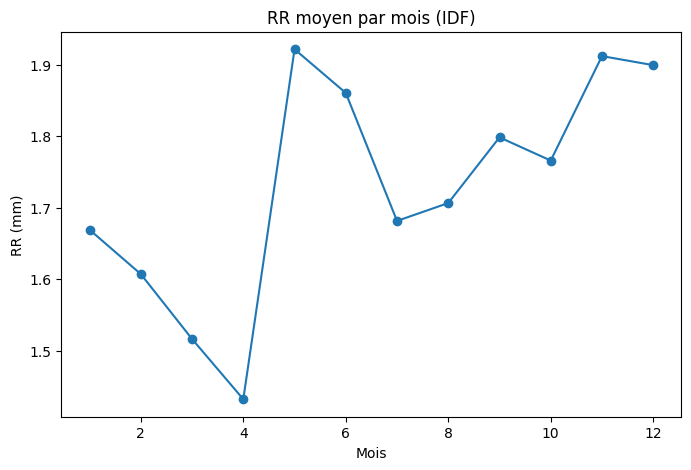

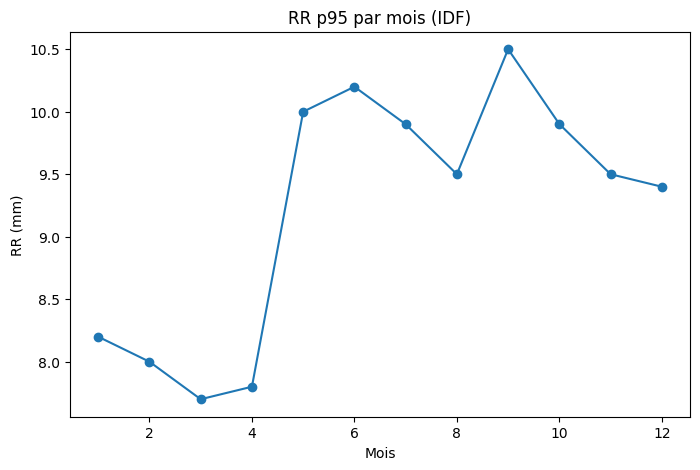

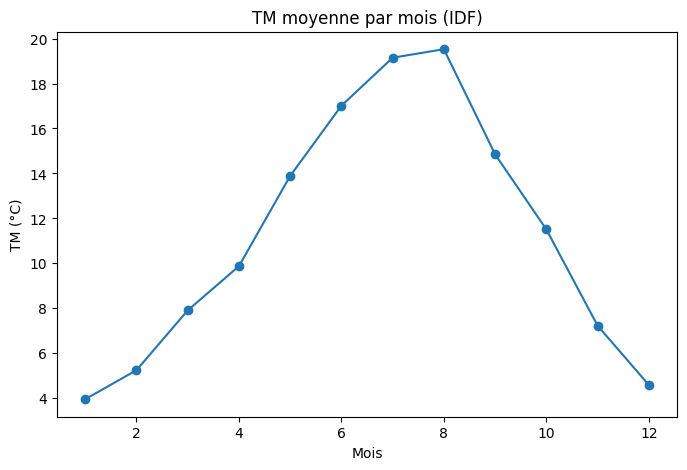

In [6]:

# RR moyen/médian par mois
monthly = (df.groupby("month")["RR"]
             .agg(rr_mean="mean", rr_median="median", rr_p95=lambda x: np.nanpercentile(x.dropna(), 95)))

fig, ax = plt.subplots(figsize=(8,5))
monthly["rr_mean"].plot(ax=ax, marker="o")
ax.set_title("RR moyen par mois (IDF)")
ax.set_xlabel("Mois")
ax.set_ylabel("RR (mm)")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
monthly["rr_p95"].plot(ax=ax, marker="o")
ax.set_title("RR p95 par mois (IDF)")
ax.set_xlabel("Mois")
ax.set_ylabel("RR (mm)")
plt.show()

# TM moyen par mois
tm_monthly = df.groupby("month")["TM"].mean()
fig, ax = plt.subplots(figsize=(8,5))
tm_monthly.plot(ax=ax, marker="o")
ax.set_title("TM moyenne par mois (IDF)")
ax.set_xlabel("Mois")
ax.set_ylabel("TM (°C)")
plt.show()


## 5. Épisodes pluvieux intenses (seuil p95 par station)

In [7]:

# Seuil p95 RR par station (sur RR>0 pour se focaliser sur jours de pluie)
def station_threshold_p95(s: pd.Series):
    s_pos = s[s > 0]
    if len(s_pos) == 0:
        return np.nan
    return np.nanpercentile(s_pos, 95)

thresholds = df.groupby("NUM_POSTE")["RR"].apply(station_threshold_p95).rename("rr_p95").to_frame()
thresholds = thresholds.dropna()
thresholds.head()


C:\Users\djahe\AppData\Local\Temp\ipykernel_30684\875423593.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  thresholds = df.groupby("NUM_POSTE")["RR"].apply(station_threshold_p95).rename("rr_p95").to_frame()


,rr_p95
NUM_POSTE,
75101001,12.0
75104001,12.7
75105001,13.8
75106001,13.3
75107001,13.3


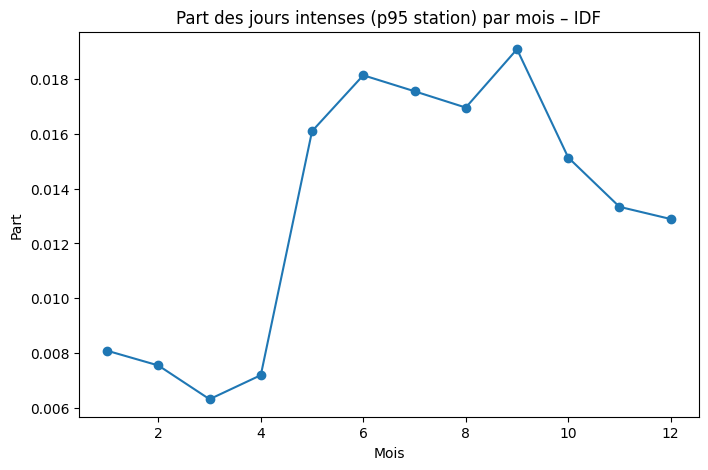

Seuils p95 par station sauvegardés → data\gold\labels_thresholds.json


In [8]:

# Marque intense par station
df = df.merge(thresholds, on="NUM_POSTE", how="left")
df["is_intense"] = (df["RR"] >= df["rr_p95"]).astype("Int64")

# Fréquence d'intenses par mois (global IDF)
intense_by_month = df.groupby("month")["is_intense"].mean()
fig, ax = plt.subplots(figsize=(8,5))
intense_by_month.plot(ax=ax, marker="o")
ax.set_title("Part des jours intenses (p95 station) par mois – IDF")
ax.set_xlabel("Mois"); ax.set_ylabel("Part")
plt.show()

# Sauvegarde des seuils pour Gold (facultatif)
out_dir = Path("data/gold"); out_dir.mkdir(parents=True, exist_ok=True)
(thresholds.reset_index()
          .rename(columns={"NUM_POSTE":"station"})
          .to_json(out_dir / "labels_thresholds.json", orient="records", force_ascii=False))
print("Seuils p95 par station sauvegardés →", out_dir / "labels_thresholds.json")


## 6. API (saturation) et intensité

In [ ]:

# Relation simple API vs probabilité d'intense (binning API)
df_api = df[["API","is_intense"]].dropna().copy()
df_api["api_bin"] = pd.qcut(df_api["API"], q=10, duplicates="drop")
prob_by_bin = df_api.groupby("api_bin")["is_intense"].mean()

fig, ax = plt.subplots(figsize=(10,5))
prob_by_bin.plot(ax=ax, marker="o")
ax.set_title("Probabilité d'épisode intense en fonction de l'API (déciles)")
ax.set_xlabel("Déciles d'API"); ax.set_ylabel("Part intense")
plt.show()


## 7. Couverture temporelle & fréquence des intenses (année × mois)

TypeError: Image data of dtype object cannot be converted to float

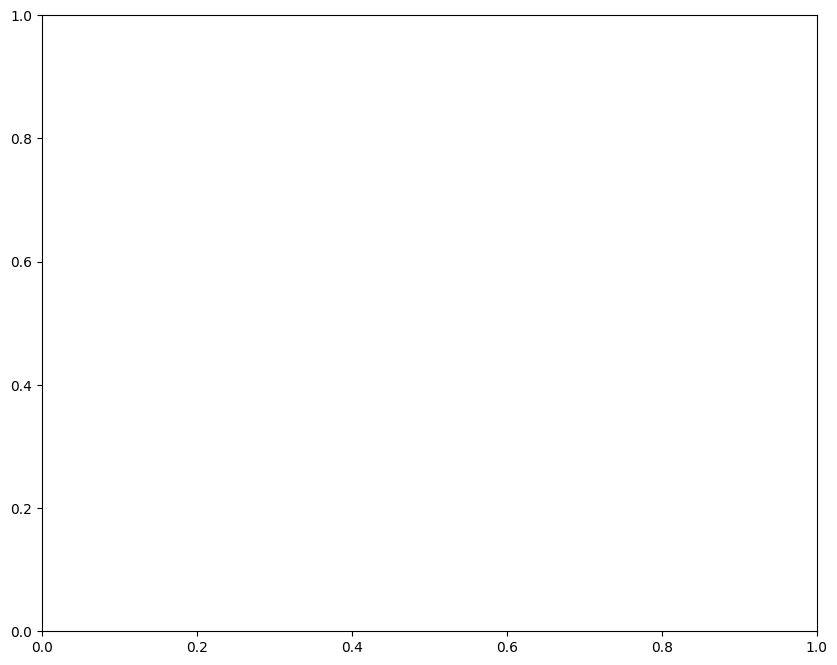

In [10]:

df["year_month"] = df["date"].dt.to_period("M").astype(str)
freq_intense = df.groupby("year_month")["is_intense"].mean().rename("part_intense").to_frame()
freq_intense = freq_intense.reset_index()
freq_intense["year"] = freq_intense["year_month"].str[:4].astype(int)
freq_intense["month"] = freq_intense["year_month"].str[5:7].astype(int)

# Tableau croisé (année x mois) de la part d'intenses
pivot = freq_intense.pivot(index="year", columns="month", values="part_intense").sort_index()

# Heatmap simple avec imshow (matplotlib pur)
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(pivot.values, aspect="auto", interpolation="nearest")
ax.set_title("Part d'épisodes intenses par année × mois (IDF)")
ax.set_xlabel("Mois"); ax.set_ylabel("Année")
ax.set_xticks(range(pivot.shape[1])); ax.set_xticklabels(list(pivot.columns))
ax.set_yticks(range(pivot.shape[0])); ax.set_yticklabels(list(pivot.index))
plt.colorbar(im, ax=ax, label="Part intense")
plt.show()


## 8. Corrélations utiles (proxy ML)

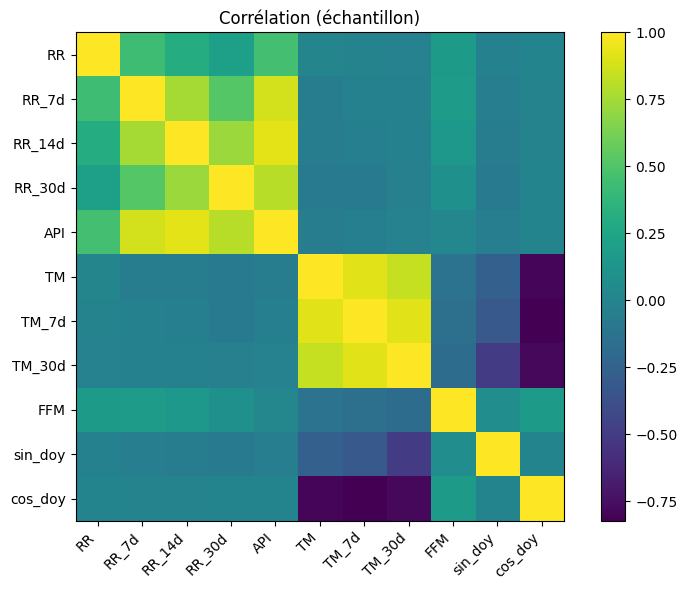

,RR,RR_7d,RR_14d,RR_30d,API,TM,TM_7d,TM_30d,FFM,sin_doy,cos_doy
RR,1.000000,0.432453,0.302787,0.207477,0.454312,0.007283,-0.006324,-0.015228,0.170769,-0.018818,-0.001564
RR_7d,0.432453,1.000000,0.753290,0.520228,0.875679,-0.052913,-0.021225,-0.018116,0.179599,-0.040154,-0.005001
RR_14d,0.302787,0.753290,1.000000,0.727407,0.923325,-0.050154,-0.038399,-0.019433,0.148446,-0.054665,-0.003582
RR_30d,0.207477,0.520228,0.727407,1.000000,0.806779,-0.071421,-0.061302,-0.030259,0.094701,-0.069211,0.003406
API,0.454312,0.875679,0.923325,0.806779,1.000000,-0.056159,-0.037559,-0.013153,0.024063,-0.039611,0.002908
TM,0.007283,-0.052913,-0.050154,-0.071421,-0.056159,1.000000,0.918762,0.840246,-0.128904,-0.262388,-0.790680
TM_7d,-0.006324,-0.021225,-0.038399,-0.061302,-0.037559,0.918762,1.000000,0.917169,-0.148241,-0.314669,-0.822058
TM_30d,-0.015228,-0.018116,-0.019433,-0.030259,-0.013153,0.840246,0.917169,1.000000,-0.179283,-0.499342,-0.782601
FFM,0.170769,0.179599,0.148446,0.094701,0.024063,-0.128904,-0.148241,-0.179283,1.000000,0.071504,0.172938
sin_doy,-0.018818,-0.040154,-0.054665,-0.069211,-0.039611,-0.262388,-0.314669,-0.499342,0.071504,1.000000,0.000646


In [11]:

corr_cols = [c for c in ["RR","RR_7d","RR_14d","RR_30d","API","TM","TM_7d","TM_30d","PMER","FFM","sin_doy","cos_doy"] if c in df.columns]
corr = df[corr_cols].sample(min(500_000, len(df))).corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_title("Corrélation (échantillon)")
ax.set_xticks(range(len(corr_cols))); ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticks(range(len(corr_cols))); ax.set_yticklabels(corr_cols)
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

corr



## 9. Prochaines étapes (vers Gold)

1. **Construction des cibles J+1** :
   - `RR_tplus1 = RR.shift(-1)` par station.
   - Classification binaire : `label_intense_j1 = 1` si `RR_tplus1 >= seuil_station (p95)`.
   - Régression : `RR_tplus1` en mm.

2. **Jeu de features J+1** (à la date t) :
   - `RR`, `RR_7d`, `RR_14d`, `RR_30d`, `API`
   - `TM`, `TM_7d`, `TM_30d`, `PMER`, `FFM`
   - `month`, `sin_doy`, `cos_doy`
   - Encodage station si nécessaire.

3. **Validation temporelle** :
   - Split 70/15/15 sur l'axe du temps.

4. **Modèles** :
   - Classification : LightGBM / RandomForest → métriques AUC, F1, rappel.
   - Régression : LightGBM / RandomForest → RMSE, MAE.

5. **Livrables** :
   - `data/gold/labels_thresholds.json` (déjà généré pour p95 station).
   - Figures (AUC, importance features), export des prédictions test.

